In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# importing libraries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Gazal
[nltk_data]     V\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gazal
[nltk_data]     V\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Gazal
[nltk_data]     V\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load the dataset
df=pd.read_csv("judge-1377884607_tweet_product_company.csv",encoding='unicode_escape')


In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# dropping the row with missing values
# since we cannot impute text
df = df.dropna(subset=['tweet_text'])

In [7]:
df['tweet_text'].duplicated().sum()

27

In [8]:
df = df.drop_duplicates(subset='tweet_text', keep='first')

In [9]:
# Drop 'emotion_in_tweet_is_directed_at' column
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [10]:
df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [11]:
df.columns

Index(['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'], dtype='object')

In [12]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

In [13]:
# dropping 'i cant tell' and No emotion toward brand or product' category since we will only be using the two sentiments.
df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell")]

In [14]:
#renaming'is_there_an_emotion_directed_at_a_brand_or_product'column to emotion to make it easy to work with
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

In [15]:
# renaming 'No emotion toward a brand a brand or product' as neutral for easy analysis
df['emotion'] = df['emotion'].replace({'No emotion toward brand or product': 'Neutral'})

In [16]:
df['emotion'].value_counts()

emotion
Neutral             5372
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64

In [17]:
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
# Function to clean text
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove hashtags (including the # symbol)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and punctuation (except spaces)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
   
     #Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

# Function to apply lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

# Apply text cleaning to the "tweet_text" column
df['cleaned_tweet'] = df['tweet_text'].apply(clean_text)

# Tokenize the "tweet_text" column
df['tokenized_tweet'] = df['cleaned_tweet'].apply(lambda x: word_tokenize(x))

# Apply lemmatization to the tokenized text
df['lemmatized_tweet'] = df['tokenized_tweet'].apply(lemmatize_text)

# Display the DataFrame with cleaned, tokenized, and lemmatized text
print(df[['tweet_text', 'cleaned_tweet', 'tokenized_tweet', 'lemmatized_tweet']])

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                                          cleaned_tweet  \
0     wesley83 i have a 3g iphone after 3 hrs tweeti...   
1     jessedee know about fludapp  awesome ipadiphon...   
2     swonderlin can not wait for  2 also they shoul...   
3     sxsw i hope this years festival isnt as crashy...

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Join the tokenized tweets into a single string with space as a separator
df['lemmatized_tweet'] = df['lemmatized_tweet'].apply(lambda x: ' '.join(x))

# Fit and transform your tokenized text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_tweet'])

# The tfidf_matrix contains the TF-IDF vectors for the tweets

In [19]:
df.head()

,tweet_text,emotion,cleaned_tweet,tokenized_tweet,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",wesley83 i have a 3g iphone after 3 hr tweetin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,jessedee know about fludapp awesome ipadiphon...,"[jessedee, know, about, fludapp, awesome, ipad...",jessedee know about fludapp awesome ipadiphone...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,swonderlin can not wait for 2 also they shoul...,"[swonderlin, can, not, wait, for, 2, also, the...",swonderlin can not wait for 2 also they should...
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,sxsw i hope this years festival isnt as crashy...,"[sxsw, i, hope, this, years, festival, isnt, a...",sxsw i hope this year festival isnt a crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,sxtxstate great stuff on fri marissa mayer go...,"[sxtxstate, great, stuff, on, fri, marissa, ma...",sxtxstate great stuff on fri marissa mayer goo...


#  Exploratory Data Analysis (EDA)

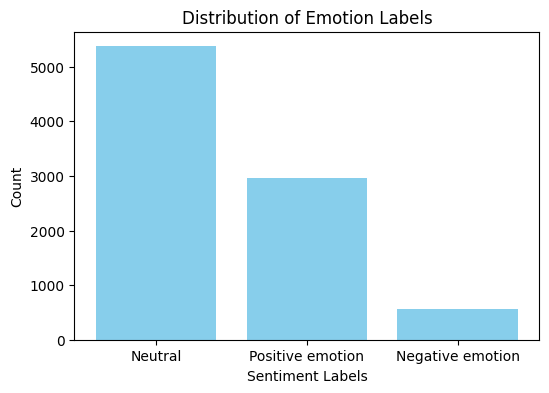

In [20]:
 #Assuming you have a DataFrame 'data' with a 'sentiment' column
sentiment_counts = df['emotion'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color="skyblue")
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels')
plt.show()

#Generating Word Clouds for Each Sentiment Class

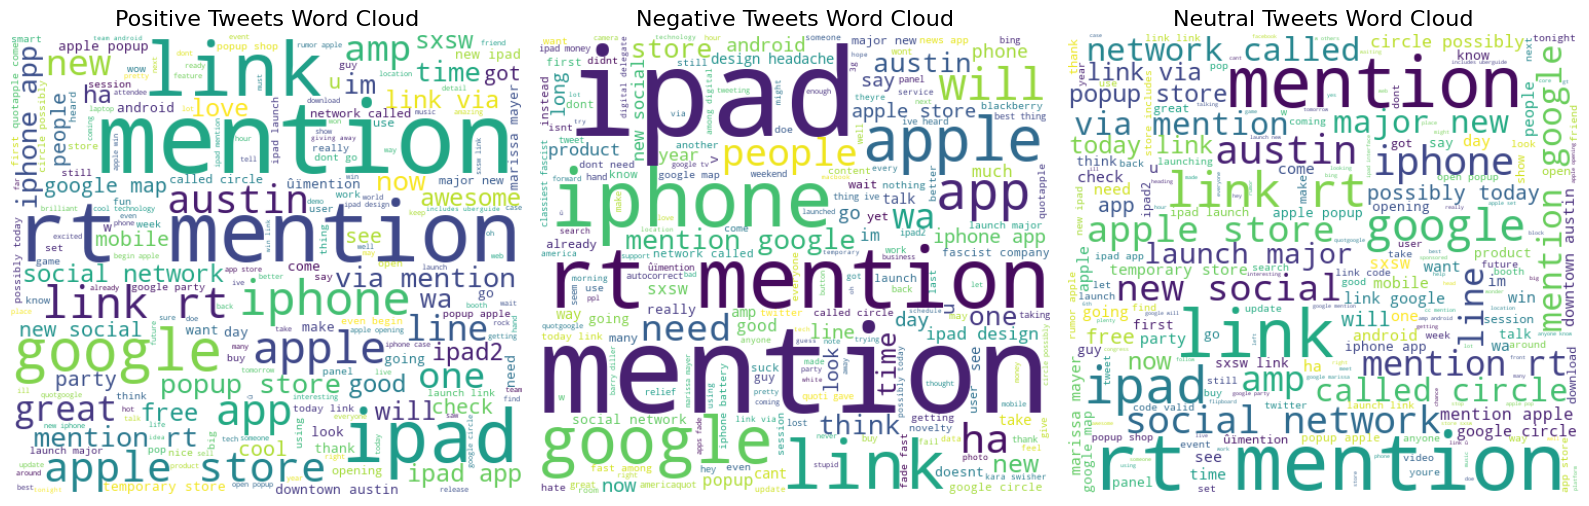

In [21]:
from wordcloud import WordCloud
# generating word count using word cloud and getting the visualization
# Separate the dataset into positive, negative, neutral, and can't tell tweets
pos_tweets = df[df['emotion'] == 'Positive emotion']['lemmatized_tweet']
neg_tweets = df[df['emotion'] == 'Negative emotion']['lemmatized_tweet']

# Filter and clean the 'neutral' tweets, handling any non-string values 
neut_tweets = df[df['emotion'] == "Neutral"]['lemmatized_tweet']
#neut_tweets = neut_tweets.dropna().astype(str)  # Convert to string and drop NaN values
# Create a 2x2 grid of subplots for word clouds
plt.figure(figsize=(16, 10))

# Function to create and display a word cloud in a specific subplot
def generate_word_cloud_subplot(text, title, position):
    wordcloud = WordCloud(width=500, height=450, background_color='white', random_state=42).generate(text)
    
    plt.subplot(1,3, position)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')

# Create word clouds for each sentiment category in specific subplots
generate_word_cloud_subplot(' '.join(pos_tweets), 'Positive Tweets Word Cloud', 1)
generate_word_cloud_subplot(' '.join(neg_tweets), 'Negative Tweets Word Cloud', 2)
generate_word_cloud_subplot(' '.join(neut_tweets), 'Neutral Tweets Word Cloud', 3)

plt.tight_layout()  # Ensures that subplots are properly arranged
plt.show()

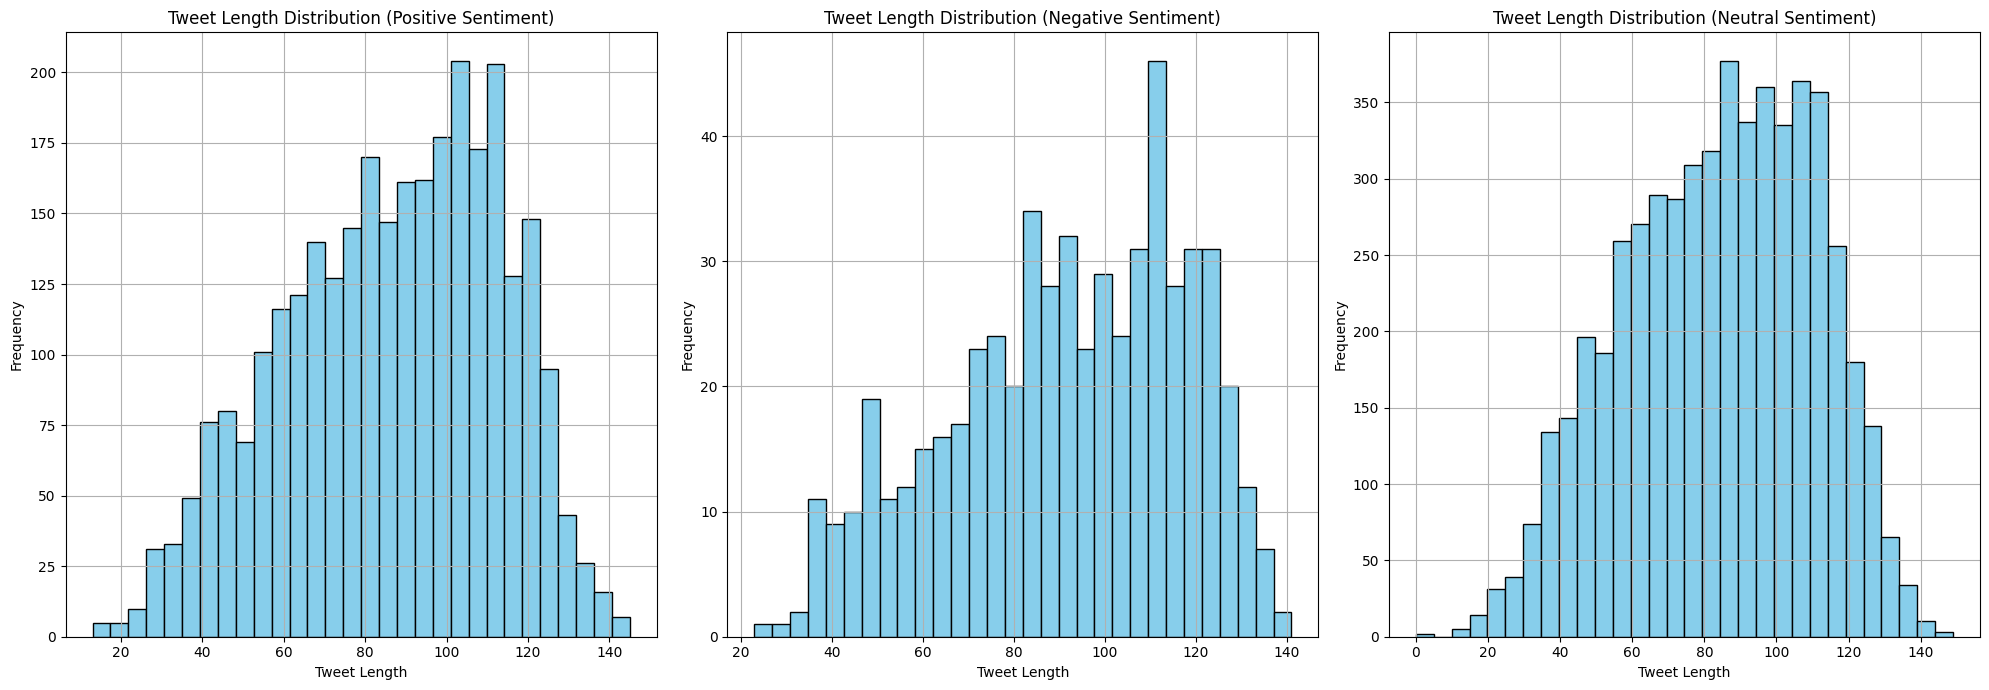

In [22]:
# checking the tweet lengths under each category
# Filter tweets by sentiment category
positive_tweets = df[df['emotion'] == 'Positive emotion']['lemmatized_tweet']
negative_tweets = df[df['emotion'] == 'Negative emotion']['lemmatized_tweet']
neutral_tweets = df[df['emotion'] == 'Neutral']['lemmatized_tweet']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Function to plot tweet length histograms
def plot_tweet_length_histograms(tweets, sentiment_label, ax):
    tweet_lengths = tweets.str.len()
    
    ax.hist(tweet_lengths, bins=30, color='skyblue', edgecolor='black')
    ax.set_xlabel('Tweet Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Tweet Length Distribution ({sentiment_label} Sentiment)')
    ax.grid(True)

# Plot histograms for each sentiment category
plot_tweet_length_histograms(positive_tweets, 'Positive', axes[0])
plot_tweet_length_histograms(negative_tweets, 'Negative', axes[1])
plot_tweet_length_histograms(neutral_tweets, 'Neutral', axes[2])

# Adjust subplots for tight layout
plt.subplots_adjust(wspace=0.4)  # Adjust the horizontal space between subplots
plt.tight_layout()  # Ensures a tight layout

# Show the plots
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder
# Encode sentiment labels
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['emotion'])

In [24]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'emotion' column to encode sentiments
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# Get the mapping of encoded values to original labels
encoded_classes = label_encoder.classes_

# Print the mapping
print("Encoded Sentiment Values:")
for code, sentiment in enumerate(encoded_classes):
    print(f"Code {code} represents '{sentiment}'")

Encoded Sentiment Values:
Code 0 represents '0'
Code 1 represents '1'
Code 2 represents '2'


In [25]:
df.head()

,tweet_text,emotion,cleaned_tweet,tokenized_tweet,lemmatized_tweet,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,wesley83 i have a 3g iphone after 3 hrs tweeti...,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",wesley83 i have a 3g iphone after 3 hr tweetin...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2,jessedee know about fludapp awesome ipadiphon...,"[jessedee, know, about, fludapp, awesome, ipad...",jessedee know about fludapp awesome ipadiphone...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,2,swonderlin can not wait for 2 also they shoul...,"[swonderlin, can, not, wait, for, 2, also, the...",swonderlin can not wait for 2 also they should...,2
3,@sxsw I hope this year's festival isn't as cra...,0,sxsw i hope this years festival isnt as crashy...,"[sxsw, i, hope, this, years, festival, isnt, a...",sxsw i hope this year festival isnt a crashy a...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,2,sxtxstate great stuff on fri marissa mayer go...,"[sxtxstate, great, stuff, on, fri, marissa, ma...",sxtxstate great stuff on fri marissa mayer goo...,2


In [26]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.20,random_state=123)

In [27]:
train_df.columns

Index(['tweet_text', 'emotion', 'cleaned_tweet', 'tokenized_tweet',
       'lemmatized_tweet', 'emotion_encoded'],
      dtype='object')

# Word2Vec Model

In [28]:
documents = [lemmatized_tweet.split() for lemmatized_tweet in train_df.lemmatized_tweet]

In [29]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=100, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [30]:
w2v_model.build_vocab(documents)

In [31]:
vocab_size = len(w2v_model.wv)

In [32]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(1881242, 3391260)

In [33]:
w2v_model.wv.most_similar("good")

[('great', 0.4496198892593384),
 ('bad', 0.4429348409175873),
 ('recommendation', 0.4402039647102356),
 ('among', 0.4382069408893585),
 ('model', 0.4257054328918457),
 ('fast', 0.42028138041496277),
 ('probably', 0.4110889136791229),
 ('bc', 0.3989827334880829),
 ('making', 0.39776793122291565),
 ('shit', 0.39488205313682556)]

In [34]:
w2v_model.wv.most_similar("hate")

[('had', 0.5344967246055603),
 ('only', 0.5128871202468872),
 ('button', 0.5119040012359619),
 ('guess', 0.5061673521995544),
 ('took', 0.4928680658340454),
 ('found', 0.4907471537590027),
 ('wa', 0.47994235157966614),
 ('am', 0.46683552861213684),
 ('stand', 0.46457913517951965),
 ('bought', 0.4582046568393707)]

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.lemmatized_tweet)

In [36]:
tokenizer.word_index

{'mention': 1,
 'the': 2,
 'link': 3,
 'to': 4,
 'at': 5,
 'rt': 6,
 'for': 7,
 'a': 8,
 'ipad': 9,
 'google': 10,
 'in': 11,
 'apple': 12,
 'of': 13,
 'is': 14,
 'and': 15,
 'store': 16,
 'on': 17,
 'iphone': 18,
 'it': 19,
 '2': 20,
 'new': 21,
 'i': 22,
 'you': 23,
 'an': 24,
 'austin': 25,
 'with': 26,
 'up': 27,
 'my': 28,
 'app': 29,
 'amp': 30,
 'launch': 31,
 'popup': 32,
 'this': 33,
 'social': 34,
 'be': 35,
 'today': 36,
 'just': 37,
 'circle': 38,
 'from': 39,
 'not': 40,
 'are': 41,
 'by': 42,
 'out': 43,
 'sxsw': 44,
 'your': 45,
 'that': 46,
 'get': 47,
 'network': 48,
 'via': 49,
 'android': 50,
 'have': 51,
 'line': 52,
 'about': 53,
 'will': 54,
 'now': 55,
 'if': 56,
 'free': 57,
 'me': 58,
 'party': 59,
 'so': 60,
 'called': 61,
 'time': 62,
 'but': 63,
 'ha': 64,
 'all': 65,
 'major': 66,
 'one': 67,
 'like': 68,
 'what': 69,
 'or': 70,
 'no': 71,
 'here': 72,
 'open': 73,
 'can': 74,
 'mobile': 75,
 'temporary': 76,
 'there': 77,
 'day': 78,
 'im': 79,
 'opening':

In [37]:
from keras_preprocessing.sequence import pad_sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.lemmatized_tweet), maxlen=300)
X_train

array([[   0,    0,    0, ...,  143,    2,  353],
       [   0,    0,    0, ...,    8,   79,  550],
       [   0,    0,    0, ..., 1451,  378,    3],
       ...,
       [   0,    0,    0, ..., 1064, 8237, 8238],
       [   0,    0,    0, ...,   15,   57,    3],
       [   0,    0,    0, ...,   36,   17,  428]])

In [38]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.lemmatized_tweet), maxlen=300)
X_test

array([[   0,    0,    0, ...,   43,   26,    1],
       [   0,    0,    0, ...,    3,   49,    1],
       [   0,    0,    0, ...,   15,   27, 1918],
       ...,
       [   0,    0,    0, ...,  395, 5866,    3],
       [   0,    0,    0, ...,  475,    7,    3],
       [   0,    0,    0, ...,  333,   18,  162]])

In [39]:
y_test=test_df.emotion
y_test.head()

1761    1
8642    1
3040    0
1614    1
5441    1
Name: emotion, dtype: int32

In [40]:
y_train=train_df.emotion
y_train.head()

7606    1
3898    1
327     1
1127    1
4226    2
Name: emotion, dtype: int32

In [41]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

8240

In [42]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(8240, 100)


In [43]:
from keras.layers import Embedding
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False)

# Build Model using LSTM

In [44]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         824,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 824,000 (3.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 824,000 (3.14 MB)

In [45]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
model.fit(X_train,y_train,epochs=5)

Epoch 1/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.5978 - loss: -33.3808
Epoch 2/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.5970 - loss: -40.3348
Epoch 3/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.6069 - loss: -43.6728
Epoch 4/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5953 - loss: -51.9478
Epoch 5/5
 35/223 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.5964 - loss: -54.5936

In [47]:
pred_test =model.predict(X_test)>0.5

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


In [48]:
# Accuracy
from sklearn import metrics
metrics.accuracy_score(y_test,pred_test)

0.621773288439955